# Resolution Parameters

This Jupyter notebook attempts to systematically change the output size of the maps generated by Unet, and then find the best choice of resolution by minimizing Chi^2. The goal is that processes described here, particularly the image comparison display code, can be transferable to optimizing other parameters.

First, mount the drive and import the necessary packages

In [2]:
# MOUNTING THE DRIVE 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername of the unzipped folder
FOLDERNAME = 'unet-master'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/unet-master


In [3]:
# IMPORTING PACKAGES
from model import *
from data import *

def saveResult(save_path,width,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"{size}_predict.png".format(size = width)),img)

import matplotlib.image as mpimg
test_dir = 'data/resolution_test/'

from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

from chi2test import *

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

0.png is actually originally 8.png in the test set

We'll now output several predicted maps of the original grain image, changing the dimension with each image

In [ ]:
#Reminders
for i in [4,6,8,9,10,11,12,13,14,15,16,24,32]:
  print(f'{i} x 32 = {i*32}')

4 x 32 = 128
6 x 32 = 192
8 x 32 = 256
9 x 32 = 288
10 x 32 = 320
11 x 32 = 352
12 x 32 = 384
13 x 32 = 416
14 x 32 = 448
15 x 32 = 480
16 x 32 = 512
24 x 32 = 768
32 x 32 = 1024


In [4]:
widths = [] #Stores the image sizes you want to test
for x in range (4,28,1):
  widths.append(32*x)
print("selected image output sizes:",widths)
#You need the image size to be a multiple of 2^5 = 32 because of the way or number of times the layers pool

def predict(w,weights):
    testGene = testGenerator("data/resolution_test")
    model = unet(input_size=(w,w,1))
    model.load_weights(weights)
    results = 255 * model.predict_generator(testGene, 1, verbose=1)
    saveResult("data/resolution_test", str(w), results.astype('uint8'))

def generate_predictions(widths):
  for w in widths:
    #Define the testGenerator to the correct size
    def testGenerator(test_path,num_image = 30,target_size = (w,w),flag_multi_class = False,as_gray = True):
      for i in range(num_image):
          img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
          img = img / 255
          img = trans.resize(img,target_size)
          img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
          img = np.reshape(img,(1,)+img.shape)
          yield img

    #Do testing on each image, skipping if it was already done
    #If you load in new weights, then you MUST either save all your images somewhere 
    #and delete them OR replace ... Huh? Build this to be more generalizable soon esp since weights is a parameter
    try:
      results = mpimg.imread(f'{test_dir}{w}_predict.png')
      print(f'image {w}_predict.png already exists') #; located in test_dir
    except FileNotFoundError:
      predict(w,weights="2000-3-weights.hdf5")
      print(f'successfully generated {w}_predict.png')
  
generate_predictions(widths)

selected image output sizes: [128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800, 832, 864]
image 128_predict.png already exists
image 160_predict.png already exists
image 192_predict.png already exists
image 224_predict.png already exists
image 256_predict.png already exists
image 288_predict.png already exists
image 320_predict.png already exists
image 352_predict.png already exists
image 384_predict.png already exists
image 416_predict.png already exists
image 448_predict.png already exists
image 480_predict.png already exists
image 512_predict.png already exists
image 544_predict.png already exists
image 576_predict.png already exists
image 608_predict.png already exists
image 640_predict.png already exists
image 672_predict.png already exists
image 704_predict.png already exists
image 736_predict.png already exists
image 768_predict.png already exists
image 800_predict.png already exists
image 832_predict.png already exists

selected image output sizes: [128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024]

Let's now define some post processing functions

Produce thresh skeletonized processed versions of all images

In [5]:
def process(w,tail):
  im_path = f'{test_dir}{w}{tail}.png'
  image = io.imread(im_path)
  threshold = np.zeros(image.shape)
  threshold[image < 253] = 1
  skeleton = morphology.skeletonize(threshold)
  skel = 255 * skeleton
  return skel

def generate_processed(widths):
  for w in widths: 
    #Do testing on each image, skipping if it was already done
    try:
      results = mpimg.imread(f'{test_dir}{w}_processed.png')
      print(f'image {w}_processed.png already exists') #; located in test_dir
    except FileNotFoundError:
      skel = process(w,tail='_predict')
      io.imsave(f'{test_dir}{w}_processed.png', skel.astype('uint8')) 
      print(f'successfully generated {w}_processed.png')

generate_processed(widths)

image 128_processed.png already exists
image 160_processed.png already exists
image 192_processed.png already exists
image 224_processed.png already exists
image 256_processed.png already exists
image 288_processed.png already exists
image 320_processed.png already exists
image 352_processed.png already exists
image 384_processed.png already exists
image 416_processed.png already exists
image 448_processed.png already exists
image 480_processed.png already exists
image 512_processed.png already exists
image 544_processed.png already exists
image 576_processed.png already exists
image 608_processed.png already exists
image 640_processed.png already exists
image 672_processed.png already exists
image 704_processed.png already exists
image 736_processed.png already exists
image 768_processed.png already exists
image 800_processed.png already exists
image 832_processed.png already exists
image 864_processed.png already exists


First, ensure Traced has been converted to a format useful to us

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: data/resolution_test/Traced_processed.png is a low contrast image
  


The processed tracing should appear below. It will be very very faint


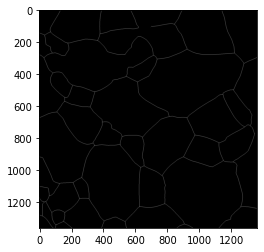

In [6]:
im_path = f'{test_dir}Traced.png'
image = io.imread(im_path)
image = color.rgb2gray(color.rgba2rgb(image))
skeleton = morphology.skeletonize(image)
skel = 255 * skeleton
io.imsave(f'{test_dir}Traced_processed.png', skel.astype('uint8')) 
plt.imshow(skel, cmap='gray')
print('The processed tracing should appear below. It will be very very faint')

Generate images of the predict overlayed on the original as well as predict & trace overlayed on the original

In [7]:
def overlay(front_path,
            back_path,
            color):
  
  img = Image.open(front_path)
  img = img.convert("RGBA")
  background = Image.open(back_path)
  background = background.convert("RGBA")

  #Color Exchange Step:
  pixdata = img.load()
  width, height = img.size
  for y in range(height):
      for x in range(width):
          if pixdata[x, y] == (255, 255, 255, 255): #FROM White
              if color == 'red':
                pixdata[x, y] = (255, 0, 0, 255) #TO Red
              if color == 'green':
                pixdata[x, y] = (0, 255, 0, 255) #TO Green
              if color == 'blue':
                pixdata[x, y] = (0, 0, 255, 255) #TO Blue

          #This step makes the black background transparent so you can see the original through it
          if pixdata[x, y] == (0, 0, 0, 255): #FROM Black
              pixdata[x, y] = (0, 0, 0, 0) #TO Transparency

  # Downsample the background to fit the front img if it doesn't already
  size = img.size
  background = background.resize(size,Image.ANTIALIAS)
  # Paste the img over background
  background.paste(img, (0, 0), img)
  return background

def generate_overlays(widths):
  for w in widths:
    #PART I
    # Put predict on orig
    try:
      results = mpimg.imread(f'{test_dir}{w}_predict_on_orig.png')
      print(f'image {w}_predict_on_orig.png already exists') #; located in test_dir'
    except FileNotFoundError:
      front_path = f'{test_dir}{w}_processed.png'
      back_path = 'data/resolution_test/0.png'
      over = np.array(overlay(front_path,back_path,'red'))
      io.imsave(f'{test_dir}{w}_predict_on_orig.png', over.astype('uint8'))
      print(f'successfully generated {w}_predict_on_orig.png')

    #PART II
    # Put predict AND trace on orig

    # Step 1: Put trace on orig (correctly sized)
    try:
      results = mpimg.imread(f'{test_dir}{w}_traceover.png')
      #print(f'image {w}_tracing.png already exists; located in test_dir')
    except FileNotFoundError:
      tracing = mpimg.imread('data/resolution_test/Traced_processed.png')
      
      # Resize the tracing
      tracing_resized = resize(tracing, (w,w), anti_aliasing=True)
      
      # Re thresh skeletonize
      threshold = np.zeros((w,w))
      threshold[tracing_resized > 0] = 1
      skeleton = morphology.skeletonize(threshold)
      skel = 255 * skeleton
      io.imsave(f'{test_dir}{w}_tracing.png', skel.astype('uint8'))
      
      # Stack
      front_path = f'{test_dir}{w}_tracing.png'
      back_path = 'data/resolution_test/0.png'
      over = np.array(overlay(front_path,back_path,'blue'))
      io.imsave(f'{test_dir}{w}_traceover.png', over.astype('uint8'))
      print(f'successfully generated {w}_traceover.png')

    # Step 2: Put predict on traceover
    try:
      results = mpimg.imread(f'{test_dir}{w}_both_on_orig.png')
      print(f'image {w}_both_on_orig.png already exists') #; located in test_dir
    except FileNotFoundError:
      front_path = f'{test_dir}{w}_processed.png'
      back_path = f'{test_dir}{w}_traceover.png'
      over = np.array(overlay(front_path,back_path,'red'))
      io.imsave(f'{test_dir}{w}_predict_on_orig.png', over.astype('uint8'))
      print(f'successfully generated {w}_both_on_orig.png')

generate_overlays(widths)

image 128_predict_on_orig.png already exists
image 128_both_on_orig.png already exists
image 160_predict_on_orig.png already exists
image 160_both_on_orig.png already exists
image 192_predict_on_orig.png already exists
image 192_both_on_orig.png already exists
image 224_predict_on_orig.png already exists
image 224_both_on_orig.png already exists
image 256_predict_on_orig.png already exists
image 256_both_on_orig.png already exists
image 288_predict_on_orig.png already exists
image 288_both_on_orig.png already exists
image 320_predict_on_orig.png already exists
image 320_both_on_orig.png already exists
image 352_predict_on_orig.png already exists
image 352_both_on_orig.png already exists
image 384_predict_on_orig.png already exists
image 384_both_on_orig.png already exists
image 416_predict_on_orig.png already exists
image 416_both_on_orig.png already exists
image 448_predict_on_orig.png already exists
image 448_both_on_orig.png already exists
image 480_predict_on_orig.png already exist

Calculate chi2 values for each of the resolution gen maps vs the traced map. Normalize them to account for image size.

In [9]:
#This cell is purely a manual test of chi2 you can just skip ahead

#Read images
img1 = mpimg.imread('data/resolution_test/256_processed.png')
img2 = mpimg.imread('data/resolution_test/Traced.png')
img2 = color.rgb2gray(color.rgba2rgb(img2))
img3 = mpimg.imread(f'{test_dir}Traced_processed.png')

#Make both the same size
image_resized = resize(img3, (img1.shape[0],img1.shape[1]), anti_aliasing=True)

#Re Thresh Skeletonize
threshold = np.zeros(image_resized.shape)
threshold[image_resized > 0] = 1
skeleton = morphology.skeletonize(threshold)
skel = 255 * skeleton
#plt.imshow(skel,cmap='gray')

print('chi 2 =',find_chi2(img1,skel))


chi 2 = 126172


In [14]:
# Find chi2 scores for each resolution
#widths = [128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832]

def generate_chi2list(widths,bundle):
  reslist,chi2list = bundle

  for w in widths: 
    if w not in reslist:
      gen = mpimg.imread(f'{test_dir}{w}_processed.png')
      trace = mpimg.imread(f'{test_dir}{w}_tracing.png')
      chi2 = find_chi2(gen,trace)
      reslist.append(w)
      chi2list.append(chi2/w**2) #what is the correct normalizing factor? boundary length? ask !!
      print(f'point {w} has been added')
    else:
      print(f'{w} already calculated')
      #pass
  return (reslist,chi2list)

#reslist = [] #comment me out after the first run is done
#chi2list = [] #comment me out after the first run is done

bundle = (reslist,chi2list) #package existing data and send it thru generator to add missing points according to widths
reslist, chi2list = generate_chi2list(widths,bundle) #spit it back out
print('list of resolutions:',reslist)
print('calculated \"norm" chi2 values:',chi2list)

128 already calculated
160 already calculated
192 already calculated
224 already calculated
256 already calculated
288 already calculated
320 already calculated
352 already calculated
384 already calculated
416 already calculated
448 already calculated
480 already calculated
512 already calculated
544 already calculated
576 already calculated
608 already calculated
640 already calculated
672 already calculated
704 already calculated
736 already calculated
768 already calculated
800 already calculated
832 already calculated
864 already calculated
list of resolutions: [128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800, 832, 864]
calculated "norm" chi2 values: [0.87225341796875, 1.368828125, 1.2357855902777777, 1.7722217793367347, 1.92523193359375, 1.8098837770061729, 1.614375, 1.5221058238636365, 1.1721733940972223, 1.1532740846893492, 1.1701610331632653, 1.116072048611111, 1.0129280090332031, 1.043901384083045, 1.046932267554012

In [194]:
# ignore me
#chi2list_denorm = [ chi2list[i]*reslist[i]**2 for i in range(len(reslist))]
#chi2list_denorm

[]

Compare resolution vs. norm chi2 to find the optimal output size

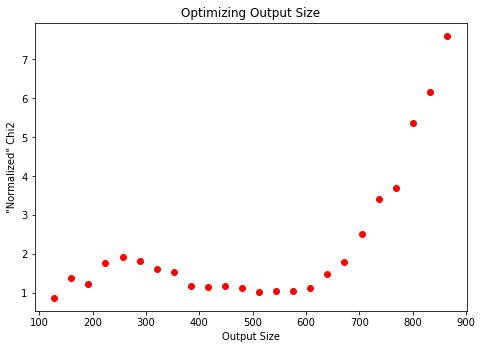

In [15]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(reslist, chi2list, color='r')
ax.set_xlabel('Output Size')
ax.set_ylabel('\"Normalized" Chi2')
ax.set_title('Optimizing Output Size')
plt.show()

fig.savefig('optimizer_traced.png')

Visualize the results by comparing images in a matrix form

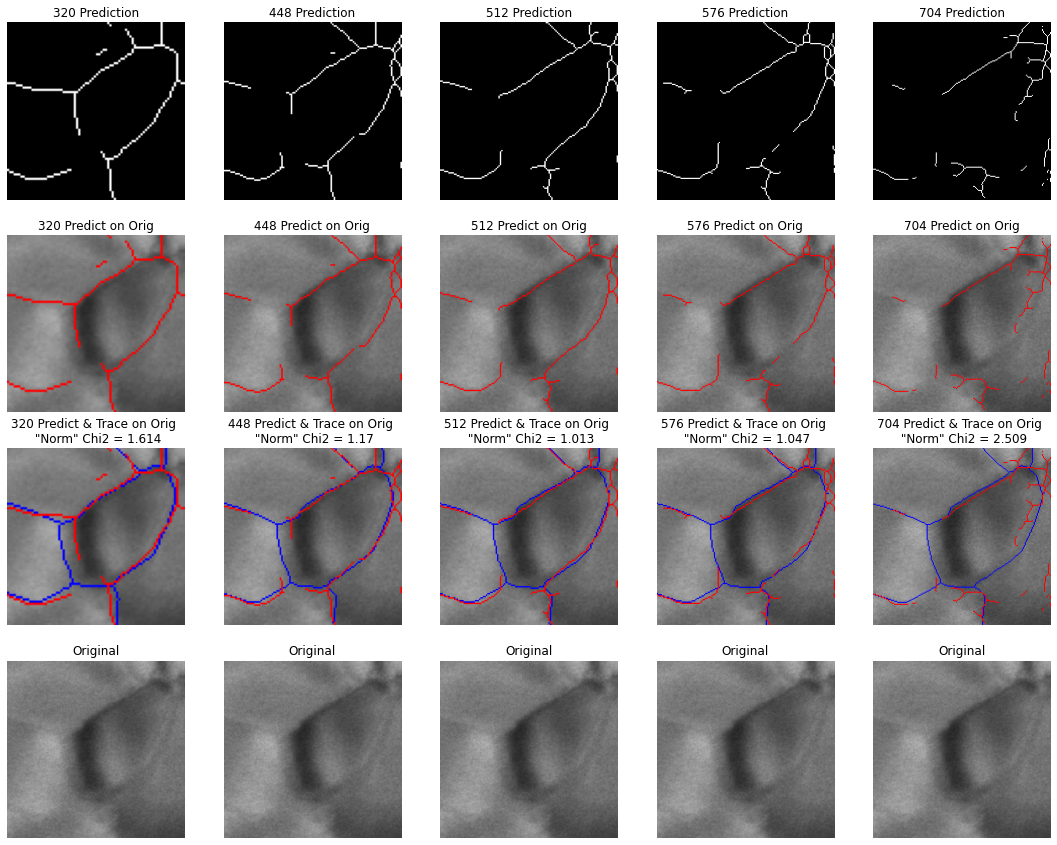

In [17]:
# Display

#Read the Resolutions to visually compare from Testers list 
testers = [320, 448, 512, 576, 704]

reservoir = [[],[],[],[]]

for i in testers: 
    reservoir[0].append((f'{test_dir}{i}_processed.png',f'{i} Prediction'))
    reservoir[1].append((f'{test_dir}{i}_predict_on_orig.png',f'{i} Predict on Orig'))
    chi = round(chi2list[reslist.index(i)],3)
    reservoir[2].append((f'{test_dir}{i}_both_on_orig.png',f'{i} Predict & Trace on Orig \n "Norm" Chi2 = {chi}'))
    reservoir[3].append((f'{test_dir}0.png','Original'))

# Set your canvas (fig) and the number of axes (images) you want to display
fig, axs = plt.subplots(nrows=4,ncols=len(testers),figsize=(15*len(testers)/4,15))

for j in range(0,len(testers)):
  for i in range(0,4):
    path, title = reservoir[i][j]

    image = mpimg.imread(path)

    #This section lets you zoom in on a 1/16th of the image 
    # so you can better see what's going on
    size = image.shape[0]
    q = int(size/4)
    n = 2
    m = 3
    image = image[n*q:(n+1)*q,m*q:(m+1)*q]

    # 2,1
    # 2,3

    axs[i][j].imshow(image, cmap='gray')
    axs[i][j].set_title(title)
    axs[i][j].axis('off')

plt.savefig('compare_around_512.png', bbox_inches='tight')
